<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es11/MetodiAI_Fis2022_Es11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of OpenAI Gym and implementation of simple RL models 

scope: to familiarize with development and use of simple tools for reinforcment learning using pytorch as DL library 

A RL system is composed by an agent (a NN in our case) and an environment, that interact togheter 


> environement -> takes a state -> observed by agent <p>
> agent -> makes an action -> afect the envrionement <p>
> environement -> takes a new states + reward -> observed by agent <p>
> ...

With trial&error methods the agent try to take better actions on the environment, so that the total reward is maximized in some way.

DL tools: pytorch + OpenAI Gym

### Models and task ###

1.   Actor-Critic RL applied to the simulated environement ***CartPole-V0***
2.   description of the ***MountainCar-v0*** environement 

## OpenAI gym

[Gym](http://gym.openai.com/): toolkit to develop simulated environments for RL studies. 

---

### CartPole-V0

Simulated env. in OpenAI gym: a pole is attached to a cart that can move to left or right directions on a binary in absence of friction. The agent have to apply a force to move the cart, and have to learn how to do that in order to prevent the pole from  falling down. 

[Detailled descritpion](http://gym.openai.com/docs/)

**Action space:** discrete and with dimension 2: accelerare left (0), accelerare right (1)

**Observable:** numpy 1D array of dimension 4: cart's horizontal position (0.0 == center) , velocity, tilt angle of the pole (0.0 == vertical), angular velocity of the pole.

**Reward:** 1 for each step carried on 

**Initial state:** random values in [-0.05, 0.05]

**Termination of an episode:** angle >= 12 deg, abs(position) > 2.4 (0==centre), or >= 200 steps

---

### MountainCar-v0

Simulated env. in OpenAI gym: a pole is attached to a cart that can move to left or right directions on a binary in absence of friction. The agent have to apply a force to move the cart, and have to learn how to do that in order to prevent the pole from  falling down.  

[Detailed description](http://gym.openai.com/envs/MountainCar-v0/)

**Action space:** discrete with dimension 3: accelerate left (0), no acceleration (1), accelerate right (2)

**Observable:** numpy 1D array of dimension 2: car's position, velocity

**Reward:** 0 if the agent is able to bring the car up to the hill (position == 0.5), -1 if the position is < 0.5

**Initial state:** random position in [-0.6,-0.4] (note: -0.5 is the position of the minimum), v=0

**Termination of an episode:** position >= 0.5 or >= 200 steps


## Setup to visualize animations in google colab


In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,492 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155632 fil

In [ ]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY

:1001


In [ ]:
import os
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from IPython import display

seed = 543
torch.manual_seed(seed)

In [ ]:
#useful function to graph the training of the RL model
def plot_results(values, title=''):   
    # Update the window after each episode
    display.clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    #ax[0].set_ylim([0,200]) 
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

### A Dummy RL algorithm 

let's try to see what will be the performances that we can get by taking random actions when acting on the cartpole  ...

In [ ]:
#initialize the envioronment 
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

[543]

In [ ]:
state = env.reset()
print('[pos,vel,angle,ang_vel] = ',state)

[pos,vel,angle,ang_vel] =  [ 0.00260174  0.02689104 -0.01369596 -0.02003628]


In [ ]:
action = 0 #let's see what appen when we takes as action 0: i.e. accelerate left

state, reward, done, _ = env.step(action)
print('[pos,vel,angle,ang_vel] = ',state)
print('reward: ', reward)
print('done: ', done)

#as expected new position coordinate is slightly < initial position (move left), and speed 
#is larger (in absolute value) and negative (left)

[pos,vel,angle,ang_vel] =  [ 0.00313956 -0.16803185 -0.01409669  0.26829414]
reward:  1.0
done:  False


runs for: 10 steps


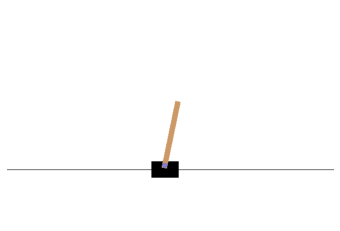

In [ ]:
# Random movement Policy

state = env.reset() # initialize the cart
img = plt.imshow(env.render(mode='rgb_array')) #plot the cart in the current status
done = False
i = 0
while not done:
    action = env.action_space.sample()  #.sample() takes a random sample of the action space of the env.
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf()) #.gfc() get the current figure in plt
    display.clear_output(wait=True) #clear the previous content of the display and plot only the last one
    state, reward, done, _ = env.step(action) #apply the action
    i = i + 1
env.close()
print('runs for: %i steps' %(i))

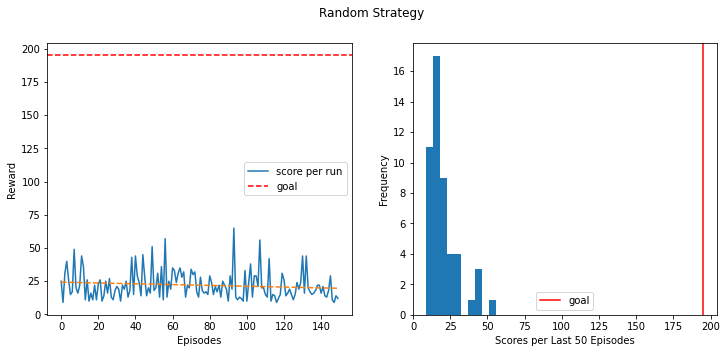

In [ ]:
# let's run 150 episodes, computing and displaying the total reward for each one to see if there are trends
# suggesting any kind of learning (we expect no as the actions are random)
episodes = 150
results = []  


for episode in range(episodes):
    state = env.reset()
    done = False 
    total = 0
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action) 
        total += reward 
    results.append(total)
    plot_results(results,title='Random Strategy')
    env.close()

### A baseline RL algorithm

Let's now try to improve the dummy algorithm by using rules based on common sense with respect the specific problem: for example if the pole tilts to the right we move to the right, and we move to the left if the pole tilts to left. 

In [ ]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

[543]

run for: 49 steps


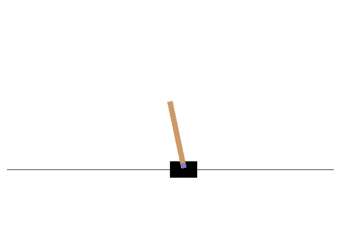

In [ ]:
# Simple Common Sense Policy
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = simple_policy(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    i = i + 1   
env.close()
print('run for: %i steps' %(i))

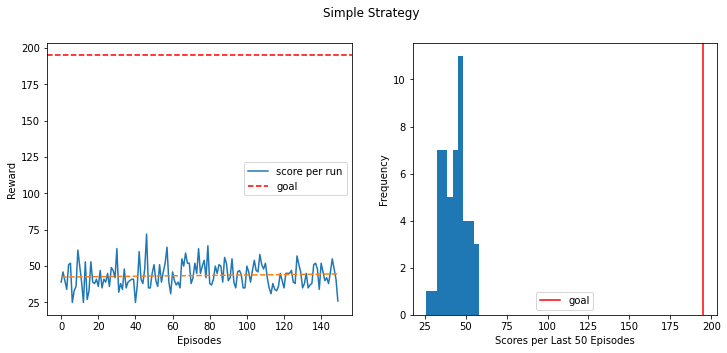

In [ ]:
# let's run 150 episodes, computing and displaying the total reward 
episodes = 150
results = []  

for episode in range(episodes):
    state = env.reset()
    done = False 
    total = 0
    while not done:
        action = simple_policy(state)
        state, reward, done, _ = env.step(action) 
        total += reward 
    results.append(total)
    plot_results(results,title='Simple Strategy')
    env.close()

... a little better of the random policy (reward ~45 wrt ~25) but still far from the solution of the problem (keep in equilibrium for >=195 steps)

### Actor Critic Method

Classic RL algorithm of the Policy Gradient type. In this type of algorithm, we directly try to optimize the agent with respect to the policy space, modeling with a DNN the probabilities associated with each action to be recommended.

In the Actor-Critic (AC) agorithm, the agent consists of two separate entities:

1. an **actor** that provides a representation of the policy: assign a set of probabilities to each possible action
2. a **critic** that is nothing more than a value function, i.e. a function of the state that estimates the sum of all the rewards that one expects to receive in the future

The critic learns how well the actor (the policy) is performing and uses this information to improve the policy itself. The improvement is obtained through Gradient Policy, i.e. updating the policy (the actor) in order to maximize the estimates of the critic's value function, in other words the agent is trained so that the actions recommended by the actor maximize the future rewards esteemed by the critic.

## ANN implementation

we use a very simple NN that learn two functions:

1. Actor: takes in input the state and predict a probability for each possible action of the action space 
2. Critic: taks in input the state and predict the total future reward (discounted)

This can be done either with two separate NN, or, as the input is the same, with just one NN with an initial shared layer (we'll use this approach as is more clean) 


In [ ]:
seed = 543
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

# Actor-Critic Model
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
num_hidden = 256

In [ ]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [ ]:
# Actor-Critic Model

# architetture: a simple MLP one input with two outputs
class A2C(nn.Module):
  def __init__(self):
    super(A2C, self).__init__()
  
    self.layercondiviso = nn.Linear(4,128)  
    self.attore = nn.Linear(128,2)
    self.critico = nn.Linear(128,1)
    
    
    # action & reward buffers
    self.saved_actions = []
    self.rewards = []
    
  def forward(self, x):
    x = F.relu(self.layercondiviso(x))
    action_prob = F.softmax(self.attore(x), dim=-1) #assign a probability to each possible action
    state_values = self.critico(x)  #predict the total discounted future reward 
        
    return action_prob, state_values

In [ ]:
model = A2C()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,num_inputs))
else:
  summary(model, input_size=(1,num_inputs))

A2C(
  (layercondiviso): Linear(in_features=4, out_features=128, bias=True)
  (attore): Linear(in_features=128, out_features=2, bias=True)
  (critico): Linear(in_features=128, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             640
            Linear-2                 [-1, 1, 2]             258
            Linear-3                 [-1, 1, 1]             129
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# optmizer
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item() # return the smallest folat so that: 1.0 + eps != 1.0


In [ ]:
# Parameters
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000

In [ ]:
# function to select the actions given a state

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state) # given the state predict the probability of each action and the future rewards
    
    m = Categorical(probs) # create a categorical distribution over the list of probabilities of actions
    action = m.sample()   # sample an action using the distribution

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()

In [ ]:
# function to run an episode (computes actor and critic losses and perform bakpropagation)

def finish_episode():

    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value (using recursive formula for discounted return)
        R = r + gamma * R
        returns.insert(0, R) #insert discounted value as first element of the list

    # normalisation 
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # use advantage A2C formulation (e.g. subtract baseline )
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss (policy gradient: log(P)*R, advantage: log(P)* (R-value estimated from critic (e.g. total discount future reward))
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss (another form of HuberLoss) (critic loss: HuberLoss(value, R))
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

## Training

In [ ]:
# useful containers
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 10

results = []
results_rr = []


for episode_count in count(1):  # Run until solved

  state = env.reset()  #initialize the environement 
  
  episode_reward = 0

  for timestep in range(1, max_steps_per_episode):

    # predict action
    action = select_action(state)

    # applies the new action
    state, reward, done, _ = env.step(action)

    model.rewards.append(reward)
    rewards_history.append(reward)
    
    episode_reward += reward

    if done:
      break

  # update the running cumulative reward 
  running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

  # backpropagation
  finish_episode()

  # log results
  if episode_count % 10 == 0:
    print('Episode {}\t Episode reward: {:.2f}\t Average (running) reward: {:.2f}'.format(
          episode_count, episode_reward, running_reward))
            
  # saves details to monitor trainign and produce useful printout
  results_rr.append(running_reward)
  results.append(episode_reward)
  #plot_results(results,title='GP Actor-Critic Strategy')
          
  # check if we have "solved" the cart pole problem
  if running_reward > env.spec.reward_threshold:
    print("Solved! Running reward is now {} and "
          "the last episode runs to {} time steps!".format(running_reward, timestep))
    break

Episode 10	 Episode reward: 9.00	 Average (running) reward: 10.68
Episode 20	 Episode reward: 11.00	 Average (running) reward: 10.78
Episode 30	 Episode reward: 29.00	 Average (running) reward: 12.55
Episode 40	 Episode reward: 12.00	 Average (running) reward: 14.56
Episode 50	 Episode reward: 16.00	 Average (running) reward: 16.89
Episode 60	 Episode reward: 73.00	 Average (running) reward: 26.71
Episode 70	 Episode reward: 55.00	 Average (running) reward: 35.77
Episode 80	 Episode reward: 38.00	 Average (running) reward: 53.38
Episode 90	 Episode reward: 42.00	 Average (running) reward: 62.99
Episode 100	 Episode reward: 52.00	 Average (running) reward: 49.95
Episode 110	 Episode reward: 49.00	 Average (running) reward: 47.38
Episode 120	 Episode reward: 92.00	 Average (running) reward: 54.85
Episode 130	 Episode reward: 115.00	 Average (running) reward: 77.78
Episode 140	 Episode reward: 200.00	 Average (running) reward: 121.99
Episode 150	 Episode reward: 182.00	 Average (running) 

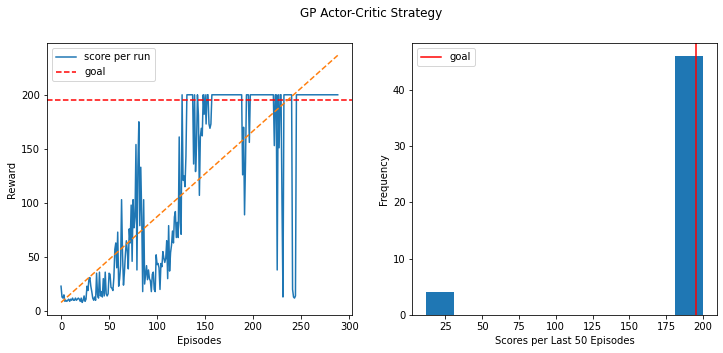

In [ ]:
#Visualize training
for episodio in range(len(results)):
  plot_results(results[:episodio],title='GP Actor-Critic Strategy')

run for: 200 steps


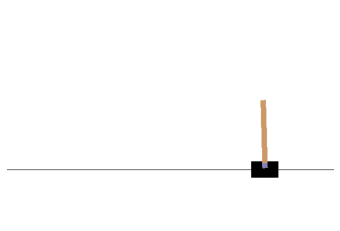

In [ ]:
# test of the trained model

model.eval()
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = select_action(state)

    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)

    i = i + 1   
env.close()
print('run for: %i steps' %(i))

### MountainCar-v0: with a baseline common sense policy

**Action space:** discrete with dimension 3: accelerate left (0), no acceleration (1), accelerate right (2)

**Observable:** numpy 1D array of dimension 2: car's position, velocity

**Reward:** 0 if the agent is able to bring the car up to the hill (position == 0.5), -1 if the position is < 0.5

**Initial state:** random position in [-0.6,-0.4] (note: -0.5 is the position of the minimum), v=0

**Termination of an episode:** position >= 0.5 or >= 200 steps

In [ ]:
seed = 543

env = gym.make("MountainCar-v0")  # Create the environment
env.seed(seed)

[543]

run for: 118 steps


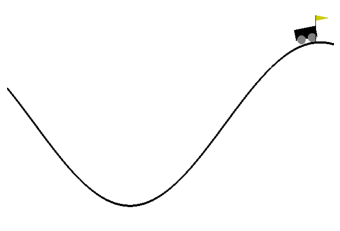

In [ ]:
# Simple common sense Policy (i.e. follows the motion direction)
def simple_policy(obs, i):
    vel = obs[1]
    pos = obs[0]+0.5 #minimum in 0
# at the first step (v=0) accelerates in downhill direction   
    if i == 0:
        return 0 if pos > 0 else 2
# in the following steps accelerates in the direction in which is already moving
    return 2 if vel > 0 else 0


# select simple or random policy
random_policy = False

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    if random_policy:
        action = env.action_space.sample() #random sampling of the action space
    else:
        action = simple_policy(state, i) #uses a common sense policy
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    i = i + 1   
env.close()
print('run for: %i steps' %(i))

In [ ]:
#useful function to graph the training of the RL model
def plot_results2(values, title=''):   
    # Update the window after each episode
    display.clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(0.5, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    #ax[0].set_ylim([0,200]) 
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(0.5, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

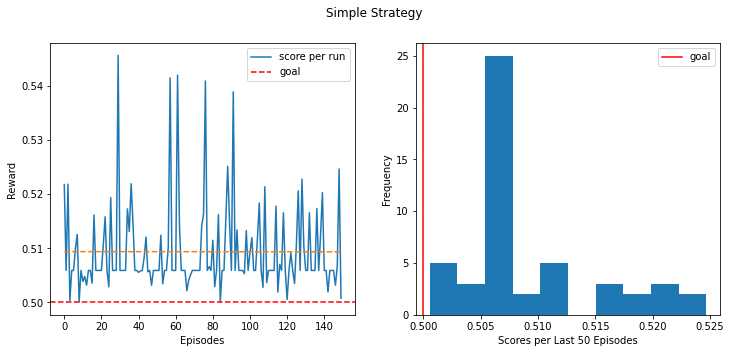

In [ ]:
# let's run 150 episodes, computing and displaying the total reward 
episodes = 150
results = []  

for episode in range(episodes):
    state = env.reset()
    done = False 
    total = state[0] #max climbing heights
    i = 0
    while not done:
        action = simple_policy(state, i)
        state, reward, done, _ = env.step(action) 
        # custom reward:
        # to takes into account that untill the cart doesn't reach 0.5 (uphill)
        # there is no reward (the standard reward is -1 for each step and 0 when arrives to the top), 
        # we redefine the reward proportional to the max position reached, e.g. an extra reward proportional 
        # to how much the cart has been able to climb up to the hill
        # NOTE: cart maximum climbing height = np.sin(3*position)*.45 + .55 
        #if state[0] >= -0.4: #i.e. to the right of the minimum
        #  reward = np.sin(3 * state[0])*.45+.55
        #else:
        #  reward = 0.0 
        if state[0]>total:
          total = state[0]
        i = i + 1
    results.append(total)
    plot_results2(results,title='Simple Strategy')
    env.close()

# Experiments ...

1.   experiment with the A2C method, modifing models parameters and RL training setup
2.   implement A2C for the *MountainCar-v0* env.
3.   you may try to simplify the A2C model, reversing to a plain Reinforce method w/o advantage (e.g. w/o critic) to check how much the speed of convergence is affected
3.   try to implement a problem with a continuous action space (for example *MountainCarContinuous-v0*)
4.   (technically quite hard) try to apply what you have learned to a more complex problem, like one of the ATARI games (technically hard, doit as nerdy thing to do during the summer (spend time doing nerdy things during the summer is not advised though).


